In [1]:
import sys
sys.path.append('../')

import graph.random_graph as random_graph
import util.create_population as create_population
import core_nn.pure_fit_model as pure_fit_model

import itertools
import torch
import pandas as pd
from matplotlib import pyplot as plt
import networkx as nx
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

class Pure_EPIS_dense(torch.nn.Module):
    def __init__(self, ISNet, psMatrices, firstTS, device="cpu", train=False, cc=None):
        super(Pure_EPIS_dense, self).__init__()
        self._n= ISNet.size()[0]
        self._models= []
        self._numVirus= len(psMatrices)
        for i in range(self._numVirus):
            model= pure_fit_model.pure_EPI_dense( ISNet, psMatrices[i], device, train=train, cc=cc)
            self._models.append(model)
        self._firstTS= firstTS
        self._device= device
        self._train= train
    def forward(self, states):# 2-1-4-n tensor, 2-10-4-1000 
        probabilityWise= torch.ones([states[0, ...].shape[0], self._n]).to(device=self._device)# the probability not a infectiveness
        newStates= []
        for i in range(self._numVirus):
            #special handle for dynamic population, first case
            currentState= torch.clone(states[i, ...])
            for j in range(currentState.shape[0]):
                if currentState[ j, 3, 0]>-1:
                    continue
                currentState[ j, 3, 0]+=1
                if currentState[ j, 3, 0]>-1:
                    currentState[ j, ...]= create_population.population(self._n, device=self._device)
                
            newState= self._models[i](currentState)
            probabilityWise*= (1-newState[:, 2])
            newStates.append(newState)
        probability= 1-probabilityWise
        return  probability.squeeze(), torch.stack(newStates)
    def parameters(self):
        parametersList=[]
        for i in range(self._numVirus):
            parametersList.append(self._models[i].parameters())
        return itertools.chain(*parametersList)
    def get_population_num(self, probability):
        return probability.sum(dim=1)
    def get_psMatrices(self):
        psMatrices= []
        for i in range(self._numVirus):
            psMatrices.append(self._models[i].get_psMatrix())
        return psMatrices

In [2]:
def sim(timeHorizon, model: Pure_EPIS_dense, states, device="cpu"):#states must be 2-1-4-n tensor
  statisticInfecteds= []
  statesInums= []
  allStates= [torch.clone(states)]
  for _ in range(timeHorizon):
    statisticI, states= model(states)
    allStates.append(torch.clone(states))
    statesInum= []
    for _,state in enumerate(states):
        stateInum= state[0, 2, :].sum()
        statesInum.append(stateInum)
    statesInum= torch.stack(statesInum)
    statesInums.append(statesInum)
    statisticInfecteds.append(statisticI)

  statisticInfecteds= torch.stack(statisticInfecteds)
  statesInums= torch.stack(statesInums) 
  allStates= torch.stack(allStates)

  return statisticInfecteds, statesInums, allStates
def filter_contributionIndex(Index:torch.tensor, threshold=1e-3):
  Index= (Index>threshold)*Index
  Index= (Index<1-threshold)*Index+(Index>1-threshold)
  return Index

In [3]:
n= 1000
avgDegree= 6
timeHorizon= 300
firstTs= [0, 80]
contact=random_graph.get_ER_random_contact(n, avgDegree, device=device)
contact = contact.requires_grad_(True)
realData =None
with torch.no_grad():
    ps1= torch.tensor([[0, 0.04, 0, 0],
                      [0, 0, 0.5, 0],
                      [0, 0, 0, 0.2],
                      [0, 0, 0, 0]], device=device)
    ps2= torch.tensor([[0, 0.1, 0, 0],
                      [0, 0, 0.4, 0],
                      [0, 0, 0, 0.04],
                      [0, 0, 0, 0]], device=device)
    pss= [ps1,ps2]
    states= create_population.static_populations(n, firstTs, device)
    model= Pure_EPIS_dense(contact, pss, firstTs, device)
    realData, statesInums, _= sim(timeHorizon, model, states)
    realData= realData.sum(dim=1)
    print(realData.shape)
    print(statesInums.shape)
contributionIndex= statesInums/(realData[..., None]+1e-20)
contributionIndex= filter_contributionIndex(contributionIndex)#filter some value to zero to save memory


torch.Size([300])
torch.Size([300, 2])


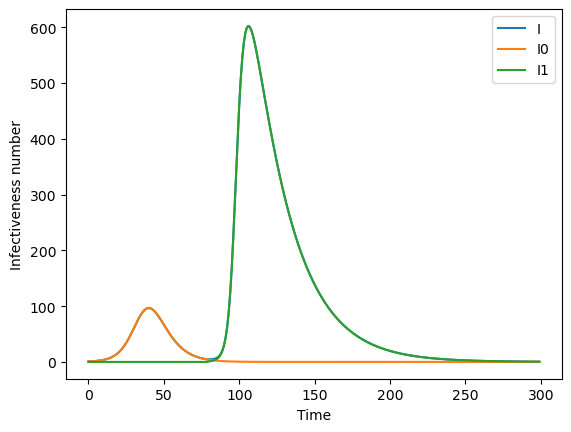

In [4]:
populationNumberPlot= realData.cpu().detach()
statesInumsPlot= statesInums.cpu().detach()
plt.plot(populationNumberPlot, label='I')
plt.plot(statesInumsPlot, label=[f"I{i}" for i in range(statesInums.shape[1])])
plt.xlabel("Time")
plt.ylabel("Infectiveness number")
plt.legend()

Text(0, 0.5, 'Contribution index')

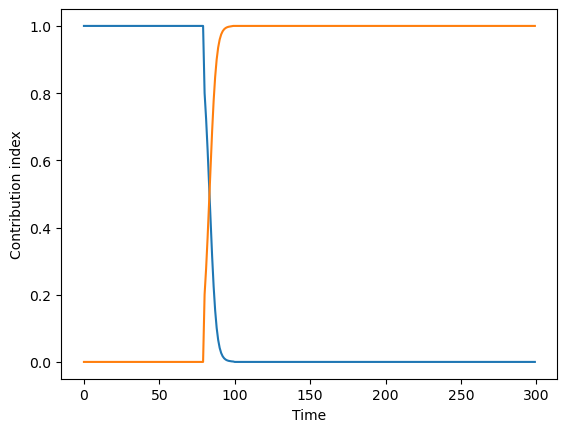

In [5]:
contributionIndexPlot= contributionIndex.cpu().detach()
plt.plot(contributionIndexPlot, label=[f"I{i}" for i in range(statesInums.shape[1])])
plt.xlabel("Time")
plt.ylabel("Contribution index")

In [71]:
windowSize= 5
batchSize= 30
realData.requires_grad_(True)
psFit1= torch.tensor([[0, 0, 0, 0],
                     [0, 0, 0.0, 0],
                     [0, 0, 0, 0.0],
                     [0.0, 0, 0, 0]], device=device)
psFit2= torch.tensor([[0, 0, 0, 0],
                     [0, 0, 0.0, 0],
                     [0, 0, 0, 0.0],
                     [0.0, 0, 0, 0]], device=device)
psFits=[psFit1, psFit2]
cc= torch.tensor([  [0, 1, 0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1],
                    [0, 0, 0, 0]], device=device)

modelFit= Pure_EPIS_dense(contact, psFits, firstTs, device, train=True, cc=cc)
lossFn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(modelFit.parameters(), lr=1e-2)

def generate_dateset(model: Pure_EPIS_dense, ys, timeHorizon=100, windowSize= 5, device="cpu"):
    with torch.no_grad():
        statesZero = create_population.static_populations(model._n, model._firstTS, device=device)
        InfectedStates, statesInums, allStates= sim(timeHorizon-windowSize-1, model, statesZero, device=device)#generate data more times?
        allStates= allStates.squeeze()
        infectiveNum=[]
        for i in range(timeHorizon-windowSize):
            infectiveNum.append(ys[i: i+windowSize])
        infectiveNum= torch.stack(infectiveNum)
        dataset = torch.utils.data.TensorDataset(allStates, infectiveNum)
        return dataset, states, InfectedStates, statesInums
#dataset, states= generate_dateset(modelFit, realData, timeHorizon, windowSize)
losses= []

In [87]:
for i in tqdm(range(100)):
    dataset, states, InfectedStates, statesFitInums= generate_dateset(modelFit, realData, timeHorizon, windowSize, device=device)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle = False)
    #with torch.autograd.set_detect_anomaly(True):
    for batch in dataloader:
        optimizer.zero_grad()
        fitY= []
        x, y = batch
        x=torch.swapaxes(x, 0, 1)
        x=[x]
        for j in range(windowSize):
            prob, newX= modelFit(x[-1])
            fitY.append(model.get_population_num(prob))
            x.append(newX)
        y= y.T
        fitY= torch.stack(fitY)
        loss= lossFn(fitY, y)
        losses.append(loss.item())
        loss.backward(retain_graph=True)
        optimizer.step()
        break

100%|██████████| 100/100 [01:24<00:00,  1.18it/s]


torch.Size([300, 2])


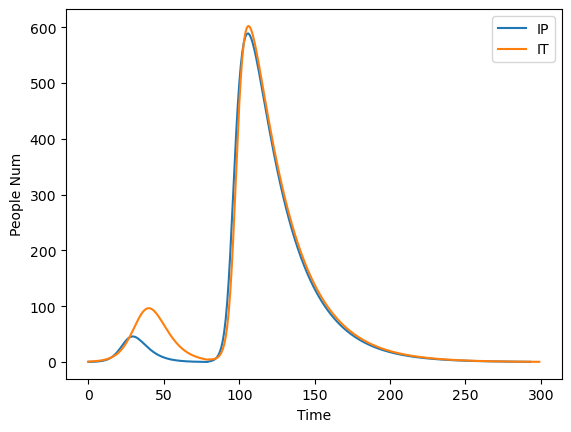

In [88]:
InfectedStatesPlot= InfectedStates.sum(1).cpu().detach()
statesFitInumsPlot= statesFitInums.cpu().detach()
print(contributionIndex.shape)
plt.plot(InfectedStatesPlot, label='IP')
plt.plot(populationNumberPlot, label='IT')
plt.xlabel("Time")
plt.ylabel("People Num")
plt.legend()

[tensor([[0.8198, 0.1802, 0.0000, 0.0000],
        [0.0000, 0.8088, 0.1912, 0.0000],
        [0.0000, 0.0000, 0.3338, 0.6662],
        [0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0',
       grad_fn=<AddBackward0>), tensor([[0.8547, 0.1453, 0.0000, 0.0000],
        [0.0000, 0.7617, 0.2383, 0.0000],
        [0.0000, 0.0000, 0.9594, 0.0406],
        [0.0000, 0.0000, 0.0000, 1.0000]], device='cuda:0',
       grad_fn=<AddBackward0>)]


Text(0, 0.5, 'loss')

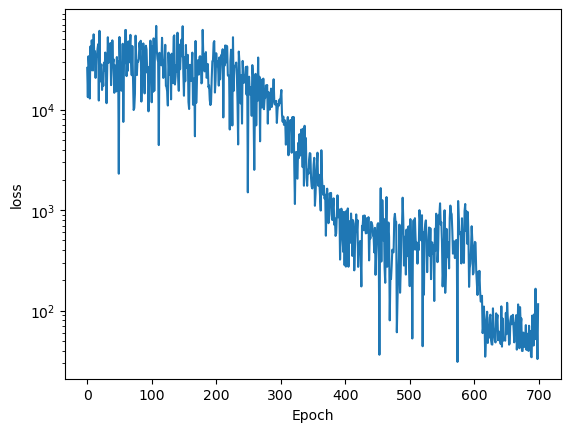

In [85]:
print(modelFit.get_psMatrices())
plt.plot(losses)
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("loss")

In [86]:
def print_model_parameters(models):
    for model in models._models:
        for name, parameter in model.named_parameters():
            print('name           : {}'.format(name))
            print('parameter      : {}'.format(parameter))
            print('learnable      : {}'.format(parameter.requires_grad))
            print('parameter.shape: {}'.format(parameter.shape))
            print('parameter.grad: {}'.format(parameter.grad))
            print('---------------------------------')
print_model_parameters(modelFit)

name           : _psMatrix
parameter      : Parameter containing:
tensor([[ 0.0000, -1.5151,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -1.4424,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.6908],
        [ 0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0',
       requires_grad=True)
learnable      : True
parameter.shape: torch.Size([4, 4])
parameter.grad: tensor([[  0.0000,  57.1275,   0.0000,   0.0000],
        [  0.0000,   0.0000, 138.2436,   0.0000],
        [  0.0000,   0.0000,   0.0000, -37.9774],
        [  0.0000,   0.0000,   0.0000,   0.0000]], device='cuda:0')
---------------------------------
name           : _psMatrix
parameter      : Parameter containing:
tensor([[ 0.0000, -1.7719,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -1.1618,  0.0000],
        [ 0.0000,  0.0000,  0.0000, -3.1638],
        [ 0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0',
       requires_grad=True)
learnable      : True
parameter.shape: torch.Size([4, 4])
parameter.grad: tensor([[0